# Grammar Toolkit Tutorial
## Part 1: Gentle Introduction
### Plotting a tree analysis
To get started directly, we download the
[Jazz Harmony Treebank](https://github.com/DCMLab/JazzHarmonyTreebank)
and plot the tree analysis of the Jazz standard "Sunny".

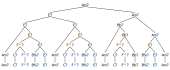

In [1]:
import AbstractGrammars as AG
import AbstractGrammars.JazzTreebank as JHT

# download and preprocess Jazz Harmony Treebank
tunes, treebank = JHT.load_tunes_and_treebank();

# the treebank entry of the Jazz standard "Sunny"
sunny = treebank[30]

# The getlabel function describes how a tree node's label is plotted.
# Feel free to change the following two lines of code to plot other tree analyses.
getlabel = t -> replace(string(t.label.val), "♭"=>"b", "♯"=>"#")
AG.plot_tree(sunny["harmony_tree"]; getlabel)

A treebank entry contains more information about a tune than just a
tree analysis of its harmonic structure.

In [2]:
sunny

Dict{String, Any} with 13 entries:
  "key"          => "a"
  "turnaround"   => 1
  "trees"        => Any[Dict{String, Any}("complete_constituent_tree"=>Dict{Str…
  "year"         => 1963
  "composers"    => "Hebb, Bobby"
  "beats"        => Any[1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1]
  "meter"        => Dict{String, Any}("denominator"=>4, "numerator"=>4)
  "measures"     => Any[1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15…
  "rhythm_tree"  => Tree{StdCategory{Rational{Int64}}}(NT(1//1), AbstractGramma…
  "chords"       => Any["Am7", "C7", "F^7", "B%7", "E7", "Am7", "C7", "F^7", "B…
  "title"        => "Sunny"
  "harmony_tree" => Tree{StdCategory{TPCC}}(NT(Am7), AbstractGrammars.Tree{Abst…
  "product_tree" => Tree{Tuple{StdCategory{TPCC}, StdCategory{Rational{Int64}}}…

If you want to read about the interpretation of such trees, see for example
the [conference paper that describes the Jazz Harmony Treebank](https://zenodo.org/record/4245406/files/80.pdf).
For an in-depth introduction to and discussion of tree analyses for harmonic
structures in Jazz, see
[Rohrmeier (2020) *The Syntax of Jazz Harmony: Diatonic Tonality, Phrase Structure, and Form*](https://doi.org/10.11116/MTA.7.1.1).

### The simplest grammar for harmonic structure
The main goal of the `AbstractGrammars.jl` package is to simplify the implementation
and application of computational grammar models that predict tree analyses.
To demonstrate the package's usage, we first consider a massively simplified
grammar (i.e., a toy example) that illustrates the API.
It consists of only four rules:
- a tonic-prolongation rule applicable to C minor chords,
  `NT(Cm) --> (NT(Cm), NT(Cm))`,
- a dominant-preparation rule that prepares a C minor chord with a G dominant-seventh chord,
  `NT(Cm) --> (NT(G7), NT(Cm))`,
- a termination rule `NT(Cm) --> T(Cm)`, and
- a termination rule `NT(G7) --> T(G7)`.
The initial category (a.k.a start symbol) of the grammar is the C minor chord
`NT(Cm)`.

In [3]:
Cm = JHT.parse_chord("Cm")
G7 = JHT.parse_chord("G7")

using AbstractGrammars: StdGrammar, T, NT, -->
rules = [
  NT(Cm) --> (NT(Cm), NT(Cm)),
  NT(Cm) --> (NT(G7), NT(Cm)),
  NT(Cm) --> T(Cm),
  NT(G7) --> T(G7),
]
init_categories = [NT(Cm)]

# construct a standard grammar
# Different types of grammars, even user defined ones, are possible
# and `StdGrammar` can be considered the simplest one.
grammar = StdGrammar(init_categories, rules);

The core of the interfaces for rules and categories consists of four functions in total.
The category type `C` is variable without restrictions and `Rule{C}` is an
abstract type that is supertype of all rule types.
```julia
isterminal(category::C)           ::Bool
isnonterminal(category::C)        ::Bool
arity(rule::Rule{C})              ::Int
apply(rule::Rule{C}, category::C) ::Union{NTuple{arity(rule), C}, Nothing}
```
The `apply` function applies a rule to a category and results either in `nothing`
if the rule is not applicable or otherwise in a tuple of `arity(rule)` many categories.
Any implementation of this interface must further guarantee that no rule is
applicable to a terminal category.

In [4]:
using AbstractGrammars: isterminal, isnonterminal, arity, apply
rule = rules[1]

NT(Cm) --> NT(Cm) NT(Cm)

In [5]:
arity(rule)

2

In [6]:
apply(rule, NT(Cm))

(NT(Cm), NT(Cm))

In [7]:
apply(rule, T(Cm)) == nothing

true

In [8]:
isterminal(NT(Cm)), isnonterminal(NT(Cm))

(false, true)

There is a generative process associated with each grammar.
It starts with a sequence consisting of one of the initial categories and recursively
applies rules to the leftmost nonterminal category of intermediate sequences until
all elements of the sequence are terminal categories.
The sequence of the applied rules is also called a *derivation*.
Consider for example the following sepwise process that results in the sequence
`[T(Cm), T(G7), T(Cm)]`.

In [9]:
derivation = [rules[i] for i in [1, 3, 2, 4, 3]] # julia arrays are one-indexed

5-element Vector{AbstractGrammars.StdRule{AbstractGrammars.StdCategory{AbstractGrammars.JazzTreebank.TPCC}}}:
 NT(Cm) --> NT(Cm) NT(Cm)
 NT(Cm) --> T(Cm)
 NT(Cm) --> NT(G7) NT(Cm)
 NT(G7) --> T(G7)
 NT(Cm) --> T(Cm)

In [10]:
seqs = [[NT(Cm)]] # seqs ... sequences
for rule in derivation
  push!(seqs, apply(rule, seqs[end]))
end
seqs

6-element Vector{Vector{AbstractGrammars.StdCategory{AbstractGrammars.JazzTreebank.TPCC}}}:
 [NT(Cm)]
 [NT(Cm), NT(Cm)]
 [T(Cm), NT(Cm)]
 [T(Cm), NT(G7), NT(Cm)]
 [T(Cm), T(G7), NT(Cm)]
 [T(Cm), T(G7), T(Cm)]

The distinction of terminals created with `T` and nonterminals created with `NT`
is necessary to avoid ambiguities with where to apply a rule by marking it as
beeing terminal.
A derivation can also be applied to a nonterminal category directly,
generating a tree analysis that traces the generative process and can be plotted for visualization.
Whether `T` and `NT` are plotted can be controlled with the `getlabel` function.

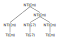

In [11]:
tree = apply(derivation, NT(Cm))
AG.plot_tree(tree; getlabel = treenode -> treenode.label, scale_width = 2)

In [12]:
AG.plot_tree(tree; getlabel = treenode -> treenode.label.val)

In [13]:
# get the terminal sequence as the leaflabels of the tree analysis
AG.leaflabels(tree)

3-element Vector{AbstractGrammars.StdCategory{AbstractGrammars.JazzTreebank.TPCC}}:
 T(Cm)
 T(G7)
 T(Cm)

### Parsing a sequence of terminal categories
Generating a sequence of terminals with a derivation from an initial category and
infering a derivation for a sequence of terminals are two sides of the same coin
and the derivation inference is called *parsing*.

In [14]:
seq = [T(Cm), T(G7), T(Cm)]
scoring = AG.CountScoring()
chart = AG.chartparse(grammar, scoring, seq)
chart[1,end]

Dict{AbstractGrammars.StdCategory{AbstractGrammars.JazzTreebank.TPCC}, Int64} with 1 entry:
  NT(Cm) => 1

Here, the important function is `chartparse`. It takes a grammar, a scoring, and
a sequence as inputs and outputs a parse chart which is a square matrix of order
`length(seq)`. Each entry `chart[i,j]` is a dictionary (i.e., a hash map)
that maps categories to scores.
There are different kinds of scores implemented in this package, one can think
about a score kind as a query type. In the example above, we used the so called
count scoring in which each score is an integer that counts the number of valid
derivations. That is, the number `chart[i,j][c]` counts the number of derivations
`d` for which `leaflabels(apply(d, c)) == seq`.
The fact that `chart[1,end][NT(Cm)] == 1` above means that there is exactly one
derivation of `seq` from the category `NT(Cm)`. And we know which one it must be!
It must be what was named `derivation` above.

There is another type of scoring that enumerates all derivations.

In [15]:
scoring = AG.AllDerivationScoring()
chart = AG.chartparse(grammar, scoring, seq)
derivations = AG.getallderivations(chart[1,end][NT(Cm)])
length(derivations)

1

In [16]:
derivations[1]

5-element Vector{AbstractGrammars.StdRule{AbstractGrammars.StdCategory{AbstractGrammars.JazzTreebank.TPCC}}}:
 NT(Cm) --> NT(Cm) NT(Cm)
 NT(Cm) --> T(Cm)
 NT(Cm) --> NT(G7) NT(Cm)
 NT(G7) --> T(G7)
 NT(Cm) --> T(Cm)

In [17]:
derivations[1] == derivation

true

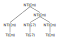

In [18]:
AG.plot_tree(apply(derivations[1], NT(Cm)); getlabel = treenode -> treenode.label, scale_width = 2)

Theoretically, all scorings can be deduced from the `AllDerivationScoring` but
the usage of `AllDerivationScoring` leads to high computation durations because
all derivations are represented explicitlely as vectors of rules.
The count scoring, for example, is much quicker because each score value is an integer
instead of a vector of vectors of rules (i.e., a vector of derivations).

Mathematically, each score type constitutes a [semiring](https://en.wikipedia.org/wiki/Semiring)
and all categories not present as keys in a chart entry are implicitly mapped to zero.
See for instance [Harasim (2020) *The Learnability of the Grammar of Jazz:
Bayesian Inference of Hierarchical Structures in Harmony*](https://infoscience.epfl.ch/record/282090)
for more information on semiring parsing.

### Probabilistic Grammar models
In real-world applications, there can be thousands and even millions of different
derivations of a (sufficiently long) sequence of terminals. A common approach
to address such ambiguities is to use probabilistic models in which each rule
application is associated with a probability.
For pedagogical reasons, we consider first a toy example with minimal ambiguity
and investigate real-world scenarios further below.
In fact, we slightly extend the scenario from above.

In [19]:
rules = [
  NT(Cm) --> (NT(Cm), NT(Cm)),
  NT(Cm) --> (NT(G7), NT(Cm)),
  NT(Cm) --> T(Cm),
  NT(G7) --> (NT(G7), NT(G7)),
  NT(G7) --> T(G7),
]
grammar = StdGrammar([NT(Cm)], rules)

seq = [T(Cm), T(G7), T(G7), T(Cm)]
scoring = AG.AllDerivationScoring()
chart = AG.chartparse(grammar, scoring, seq)
derivations = AG.getallderivations(chart[1,end][NT(Cm)])
length(derivations)

2

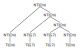

In [20]:
trees = [apply(d, NT(Cm)) for d in derivations]
AG.plot_tree(trees[1]; getlabel = treenode -> treenode.label, scale_width = 2)

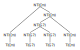

In [21]:
AG.plot_tree(trees[2]; getlabel = treenode -> treenode.label, scale_width = 2)

Thus, there are two derivations of the sequence `[T(Cm), T(G7), T(G7), T(Cm)]`
for this grammar. In the following, we assign probabilities to rule applications
by hand and use the `BestDerivationScoring` to obtain the derivation with the
highest probability. This packages provides tools to simplify this process in
real-world scenarios, which we introduct in part 2 of this tutorial.
For now, we define a custom distribution type (not optimized for efficiency)
in order to make the code as transparent as possible. This distribution is a
categorical distribution over any values of any other data type (rules in our example).

In [22]:
import Distributions: logpdf
import Base: rand
using Random: AbstractRNG
using Distributions: Categorical

struct GenericCategorical{T}
  probs :: Dict{T, Float64}
end

function logpdf(gc::GenericCategorical{T}, x::T) where T
  log(gc.probs[x])
end

function rand(rng::AbstractRNG, gc::GenericCategorical)
  i = rand(rng, Categorical(collect(values(gc.probs))))
  collect(keys(gc.probs))[i]
end

rand (generic function with 202 methods)

tests

In [23]:
begin
  gc = GenericCategorical(Dict("foo" => 0.4, "bar" => 0.6))
  @assert exp(logpdf(gc, "foo")) ≈ 0.4
  @assert exp(logpdf(gc, "bar")) ≈ 0.6
  for _ in 1:100
    @assert rand(gc) in ("foo", "bar")
  end
end

We use this custom distribution type to specify a conditional rule distribution.
To work with this package, the conditional rule distribution must be a function
that takes a category and returns a distribution over rules applicable to that
category. All scorings that use rule-application probabilities in some form then
take a conditional rule distribution as input.

In [24]:
ruledistdict = Dict(
  NT(Cm) => GenericCategorical(Dict(
              NT(Cm) --> (NT(Cm), NT(Cm)) => 1/3,
              NT(Cm) --> (NT(G7), NT(Cm)) => 1/3,
              NT(Cm) --> T(Cm)            => 1/3,
            )),
  NT(G7) => GenericCategorical(Dict(
              NT(G7) --> (NT(G7), NT(G7)) => 1/2,
              NT(G7) --> T(G7)            => 1/2,
            )),
)
ruledist = c -> ruledistdict[c]
scoring = AG.BestDerivationScoring(ruledist)
chart = AG.chartparse(grammar, scoring, seq)
logprob, derivation = AG.getbestderivation(chart[1,end][NT(Cm)])
exp(logprob)

0.001543209876543209

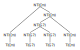

In [25]:
tree = apply(derivation, NT(Cm))
AG.plot_tree(tree; scale_width=2)

In [26]:
scoring = AG.InsideScoring(ruledist)
seq_logprob = AG.chartparse(grammar, scoring, seq)[1,end][NT(Cm)].log
best_tree_prob = exp(logprob - seq_logprob)

0.6000000000000001

## Part 2: Simple Treebank Grammar
We start this second part with implementing functions that that calculate
derivation predictions and tree prediction accuracies.
The package `ProgressMeter` is used to show progress bars.
They are initiated with the constructor `Progress` and the the function
`progress_map` as a drop-in replacement for `map`.

In [27]:
function predict_derivation(grammar, ruledist, seq, start)
  scoring = AG.BestDerivationScoringFast(ruledist, grammar)
  chart = AG.chartparse(grammar, scoring, seq)
  _logprob, derivation = AG.getbestderivation(scoring, chart[1,end][start])
  return derivation
end

using ProgressMeter: Progress, progress_map
function predict_derivations(grammar, ruledist, sequences, seq2start; showprogress=true)
  progress_msg = "calculating derivation predictions: "
  p = Progress(length(treebank); dt=0.01, desc=progress_msg, enabled=showprogress)
  progress_map(sequences; progress=p) do seq
    start = seq2start(seq)
    derivation = predict_derivation(grammar, ruledist, seq, start)
    (start, derivation)
  end
end

function prediction_accs(grammar, ruledist, tunes, seq2start, tune2tree; showprogress=true)
  progress_msg = "calculating prediction accuracies: "
  p = Progress(length(tunes); dt=0.01, desc=progress_msg, enabled=showprogress)
  progress_map(tunes; progress=p) do tune
    tree = tune2tree(tune)
    seq = AG.leaflabels(tree)
    start = seq2start(seq)
    derivation = predict_derivation(grammar, ruledist, seq, start)
    tree_prediction = apply(derivation, start)
    AG.tree_similarity(tree, tree_prediction)
  end
end

prediction_accs (generic function with 1 method)

The idea of this treebank grammar is that the set of possible rules is big and
that the probability of a rule is roughly proportional to how often that rule
is used in the treebank. Such a *smooth* treebank grammar has the benefit of
beeing robust against unseen and uncommon chord sequences.
All rules in this grammar model fall into one of 4 rule kinds:
- unary termination rules `NT(c) --> T(c)`,
- binary duplication rules `NT(c) --> NT(c) NT(c)`,
- binary right-headed rules `NT(c) --> NT(d) NT(c)`, and
- binary left-headed rules `NT(c) --> NT(c) NT(d)`
for chord symbols `c` and `d` such that `c != d`.
The function `mk_harmony_grammar` takes as input whether only right-headed,
only left-headed, or both left- and right-headed rules are included.
Termination and duplication rules are always included.

In [28]:
all_chords = collect(
  JHT.Chord(JHT.parsespelledpitch(letter * acc), form)
  for letter in 'A':'G'
  for acc in ("b", "#", "")
  for form in instances(JHT.ChordForm)
)

function mk_harmony_grammar(headedness=[:leftheaded, :rightheaded])
  ts  = T.(all_chords)  # terminals
  nts = NT.(all_chords) # nonterminals

  # termination and duplication rules are always included
  rules = [nt --> t for (nt, t) in zip(nts, ts)]
  append!(rules, [nt --> (nt, nt) for nt in nts])

  # include other rule kinds
  distinct_pairs(xs) = [(x1, x2) for x1 in xs for x2 in xs if x1 != x2]
  if :leftheaded in headedness
    append!(rules, [rhs[1] --> rhs for rhs in distinct_pairs(nts)])
  end
  if :rightheaded in headedness
    append!(rules, [rhs[2] --> rhs for rhs in distinct_pairs(nts)])
  end

  initial_categories = nts # each nonterminal is potentially an initial category
  StdGrammar(initial_categories, rules)
end

mk_harmony_grammar (generic function with 2 methods)

The probability model of the grammar is simple and already implemented in
this package as the function:
```julia
symdircat_ruledist(nonterminal_categories, all_rules, concentration_parameter)
```
In this probability model, the probabilities of the rules applicable to a
nonterminal category are drawn from a symmetrical
[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)
with concentration parameter `0.1``.

In [29]:
function mk_harmony_prior(harmony_grammar)
  AG.symdircat_ruledist(NT.(all_chords), harmony_grammar.rules, 0.1)
end

mk_harmony_prior (generic function with 1 method)

For this tutorial, we do not use left-headed rules but feel free to change that
and see how the results change.
In any case, predicting tree analyses without training the grammar on the treebank
leads to low accuracy values.

In [30]:
grammar = mk_harmony_grammar([:rightheaded])
ruledist = mk_harmony_prior(grammar)
seq2start = seq->NT(seq[end])
tune2tree = tune->tune["harmony_tree"]
accs = prediction_accs(grammar, ruledist, treebank, seq2start, tune2tree)

using Statistics: mean
mean(accs)

calculating prediction accuracies: 100%|████████████████| Time: 0:00:03


0.1801280730724471

After the rule distribution is trained using the function `observe_trees!`,
the predictions are much more accurate.

In [31]:
harmony_trees = [tune["harmony_tree"] for tune in treebank]
AG.observe_trees!(AG.treelet2stdrule, ruledist, harmony_trees)
accs = prediction_accs(grammar, ruledist, treebank, seq2start, tune2tree)
mean(accs)

calculating prediction accuracies: 100%|████████████████| Time: 0:00:03


0.5393715012489644

However, we just evaluated the model on the same data it was trained, which
is a major flaw. We address this issue using leave-one-out cross-validation (LOOCV).

In [32]:
using Random: randperm, default_rng
# k-fold cross validation for n data points
function cross_validation_index_split(num_folds, num_total, rng=default_rng())
  num_perfold = ceil(Int, num_total/num_folds)
  num_lastfold = num_total - (num_folds-1) * num_perfold
  fold_lenghts = [fill(num_perfold, num_folds-1); num_lastfold]
  fold_ends = accumulate(+, fold_lenghts)
  fold_starts = fold_ends - fold_lenghts .+ 1
  shuffled_idxs = randperm(rng, num_total)
  test_indices = [shuffled_idxs[i:j] for (i,j) in zip(fold_starts,fold_ends)]
  train_indices = [setdiff(1:num_total, idxs) for idxs in test_indices]
  return collect(zip(test_indices, train_indices))
end

import Logging
function prediction_accs_loocv(grammar, mk_ruledist, tunes, seq2start, tune2tree; showprogress=true)
  progress_msg = "calculating prediction accuracies: "
  p = Progress(length(tunes); dt=0.01, desc=progress_msg, enabled=showprogress)
  index_splits = cross_validation_index_split(length(tunes,), length(tunes))
  trees = map(tune2tree, tunes)
  Logging.disable_logging(Logging.Info)
  progress_map(index_splits; progress=p) do ((test_idx,), train_idxs)
    # train rule distribution
    ruledist = mk_ruledist() # initializing the prior distribution needs most of the time
    AG.observe_trees!(AG.treelet2stdrule, ruledist, trees[train_idxs])

    # evaluate rule distribution
    tree = trees[test_idx]
    seq = AG.leaflabels(tree)
    start = seq2start(seq)
    derivation = predict_derivation(grammar, ruledist, seq, start)
    tree_prediction = apply(derivation, start)
    AG.tree_similarity(tree, tree_prediction)
  end
end

accs = prediction_accs_loocv(grammar, ()->mk_harmony_prior(grammar), treebank, seq2start, tune2tree)
mean(accs)

calculating prediction accuracies: 100%|████████████████| Time: 0:01:28


0.46431913027974775

Mathematically, training using the treebank analytically computes the posterior
rule distribution.

TBD: add more information what this means

To wrap up this part of the tutorial, we consider the tree prediction for sunny.

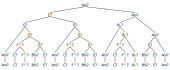

In [33]:
AG.plot_tree(sunny["harmony_tree"]; getlabel=t->t.label.val)

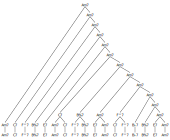

In [34]:
test_idx = 30
train_idxs = [1:test_idx-1; test_idx+1:150]
ruledist = mk_harmony_prior(grammar)
tree = harmony_trees[test_idx]
seq = AG.leaflabels(tree)
start = seq2start(seq)
derivation = predict_derivation(grammar, ruledist, seq, start)
tree_prediction = apply(derivation, start)
AG.plot_tree(tree_prediction; getlabel=t->t.label.val)

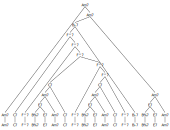

In [35]:
AG.observe_trees!(AG.treelet2stdrule, ruledist, harmony_trees[train_idxs])
derivation = predict_derivation(grammar, ruledist, seq, start)
tree_prediction = apply(derivation, start)
AG.plot_tree(tree_prediction; getlabel=t->t.label.val)

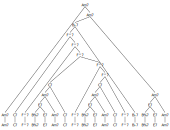

In [36]:
derivation = predict_derivation(grammar, ruledist, seq, start)
tree_prediction = apply(derivation, start)
AG.plot_tree(tree_prediction; getlabel=t->t.label.val)

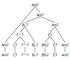

In [37]:
derivation = predict_derivation(grammar, ruledist, seq[11:end], start)
tree_prediction = apply(derivation, start)
AG.plot_tree(tree_prediction; getlabel=t->t.label.val)

We see that the grammar captures already some structure but not a lot.
It works well on the last phrase of the tune's chord sequence but it does not
work well on the whole tune.
To improve the model, we jointly consider harmony and rhythm in the next part of
the tutorial.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*